# [Epidemic Spread through Trade Routes in Medieval Europe and Asia](https://github.com/LucyWilcox/Plague/blob/master/reports/final_report.md)

## Epidemic Simulator

### Lucy Wilcox and Kaitlyn Keil

#### Complexity Science, Fall 2017

#### Olin College of Engineering

This notebook processes the simulation generated by [epidemic_simulator.ipynb](https://github.com/LucyWilcox/Plague/blob/master/code/epidemic_simulator.ipynb), a model based on the work of Gomez and Verdu’s [*Network theory may explain the vulnerability of medieval human settlements to the Black Death pandemic*](https://www.nature.com/articles/srep43467). 

In [100]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib

import networkx as nx
import numpy as np
import pandas as pd
import pickle
import csv

matplotlib.rc('ytick', labelsize = 12)
matplotlib.rc('xtick', labelsize = 12)
matplotlib.rc('axes', titlesize = 16, labelsize = 14)
# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [79]:
# Check degree of cities
loaded_city_graph = pickle.load(open('save_graph.p', 'rb'))
degree_list = list(loaded_city_graph.degree().values())

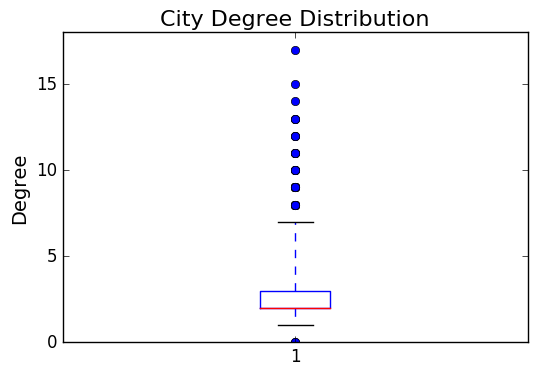

In [102]:
# Plot in similar formatting
plt.boxplot(degree_list, sym = 'o', whis = [5, 95])
plt.yticks(np.arange(0, 20, 5))
plt.ylabel("Degree")
plt.title("City Degree Distribution")

In [104]:
# Set up functions to easily plot figures

def infection_subplotter(title, df, axes):
    """ Plots the total infections and cities infected for each response rate from a transmission rate. 
    Uses two axes: left for total infections, right for cities infected
    df: dataframe of the given transmission rate.
    axes: the axes object it is being plotted on
    """
    axes2 = axes.twinx()
    mean_infections = df.groupby('quarantine')['total_infections'].mean()
    mean_cities = df.groupby('quarantine')['cities_infected'].mean()
    
    ln1 = axes.plot(mean_infections, 'bo-', label = 'Total Infections')
    ln2 = axes2.plot(mean_cities, 'ro-', label = 'Number of Infected Cities')
    axes.set_xlabel('Quarantine Response Rate')
    axes.set_ylabel('Infections')
    axes2.set_ylabel('Infected Cities')
    axes.set_title(title)
    axes.set(adjustable="datalim")
    axes2.set(adjustable="datalim")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    return lns, labs
    
def subplotting_wrapper(df_list):
    """ Given a list of 3 dataframes, makes them into subplots."""
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    lns, labs = infection_subplotter('Quarantine Effects for 0.15 Transmission', df_list[0], ax1)
    plt.legend(lns, labs)
    infection_subplotter('Quarantine Effects for 0.50 Transmission', df_list[1], ax2)
    infection_subplotter('Quarantine Effects for 0.75 Transmission', df_list[2], ax3)
    fig.set_size_inches(8, 15)

def all_on_one(df_list, isHub = False):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    counter = 0
    label_list = ['0.15', '0.5', '0.75']
    lns = []
    for df in df_list:
        mean_infections = df.groupby('quarantine')['total_infections'].mean()
        mean_cities = df.groupby('quarantine')['cities_infected'].mean()
        ln = ax.plot(mean_infections, color = COLORS[counter],marker='o', label = 'Total, '+ label_list[counter])
        ln2 = ax2.plot(mean_cities, color = COLORS[counter+3],marker='o', label = 'Infected Cities, ' +label_list[counter])
        lns += ln + ln2
        counter +=1
        
    labs = [l.get_label() for l in lns]
    ax.set_xlabel('Quarantine Response Rate')
    ax.set_ylabel('Infections')
    ax2.set_ylabel('Infected Cities')
    if isHub:
        ax.set_title('Infections for Different Transmission Rates,\nHub Cities Quarantined')
    else:
        ax.set_title('Infections for Different Transmission Rates,\nAny City Quarantined')
    plt.legend(lns, labs, bbox_to_anchor = (1.7, 1))
    fig.set_size_inches(6,6)

In [16]:
# Load the output files into Pandas DataFrames for easy parsing
all_file = "any_city_sim.csv"
hub_file = "hub_city_sim.csv"
all_quaran = pd.read_csv(all_file)
hub_quaran = pd.read_csv(hub_file)
hub_quaran.tail()

,transmission,quarantine,total_infections,cities_infected
3295,0.75,0.95,73954,911
3296,0.75,0.95,78240,959
3297,0.75,0.95,73096,919
3298,0.75,0.95,74965,928
3299,0.75,0.95,73127,920


In [5]:
# Separate the different transmission rates
all_trans_75 = all_quaran.loc[all_quaran.transmission == 0.75]
all_trans_50 = all_quaran.loc[all_quaran.transmission == 0.5]
all_trans_15 = all_quaran.loc[all_quaran.transmission == 0.15]
hub_trans_75 = hub_quaran.loc[hub_quaran.transmission == 0.75]
hub_trans_50 = hub_quaran.loc[hub_quaran.transmission == 0.5]
hub_trans_15 = hub_quaran.loc[hub_quaran.transmission == 0.15]

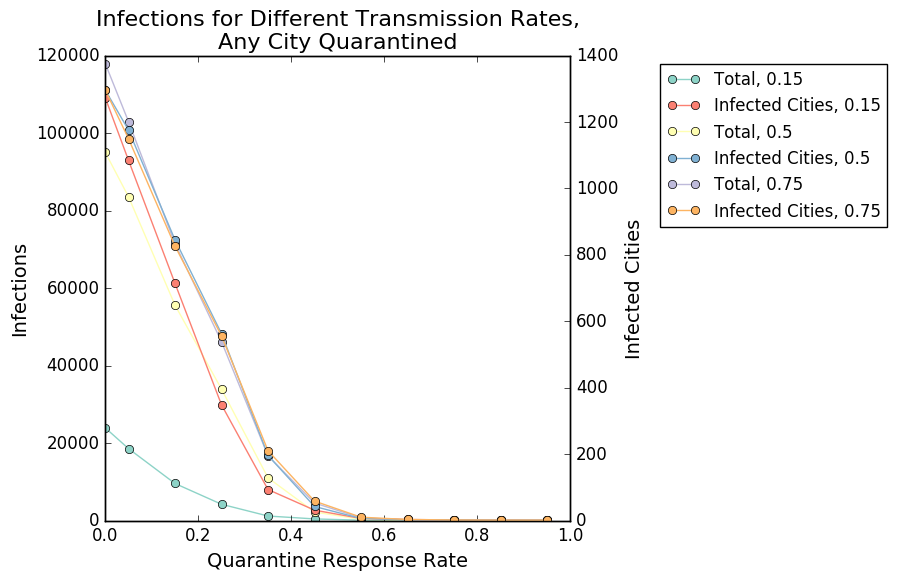

In [105]:
# Look at the infections (both total number and number of
#  cities) when any city can be quarantined
all_on_one([all_trans_15, all_trans_50, all_trans_75])

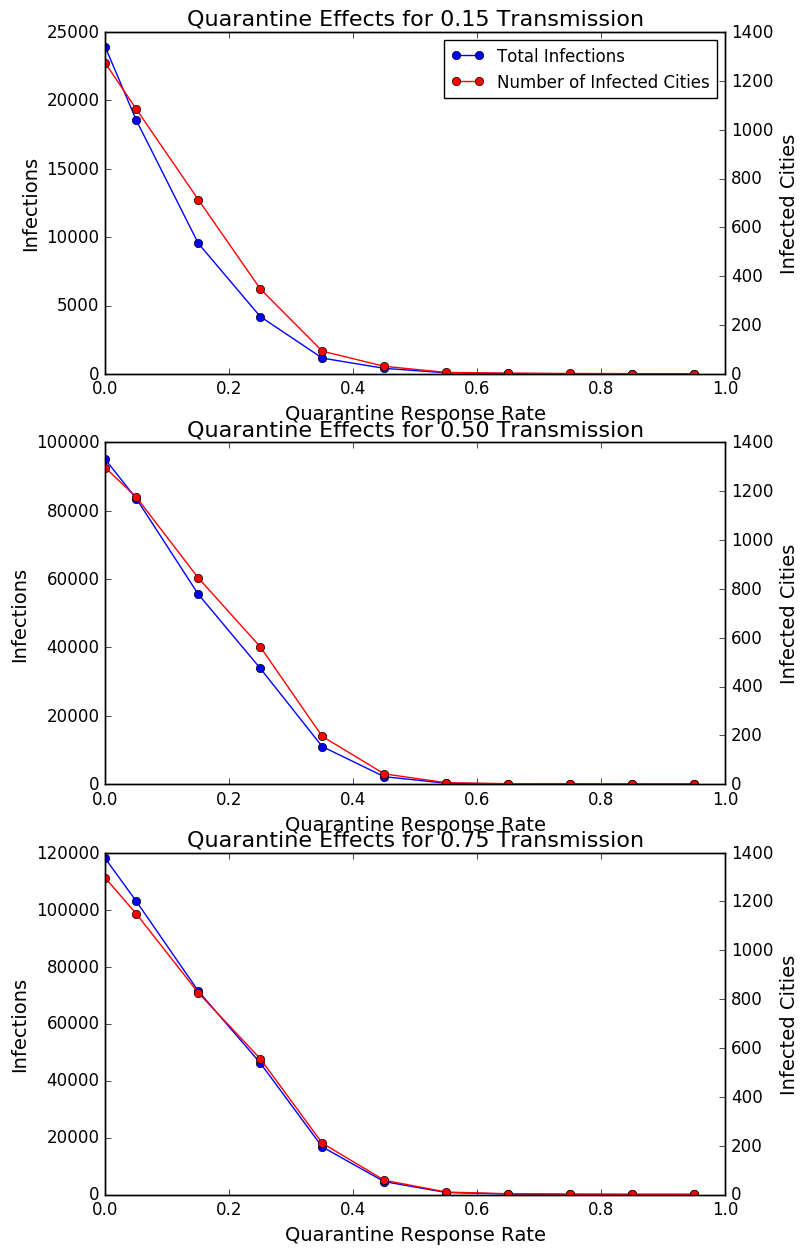

In [106]:
# Separate into individual plots for closer examination
subplotting_wrapper([all_trans_15, all_trans_50, all_trans_75])

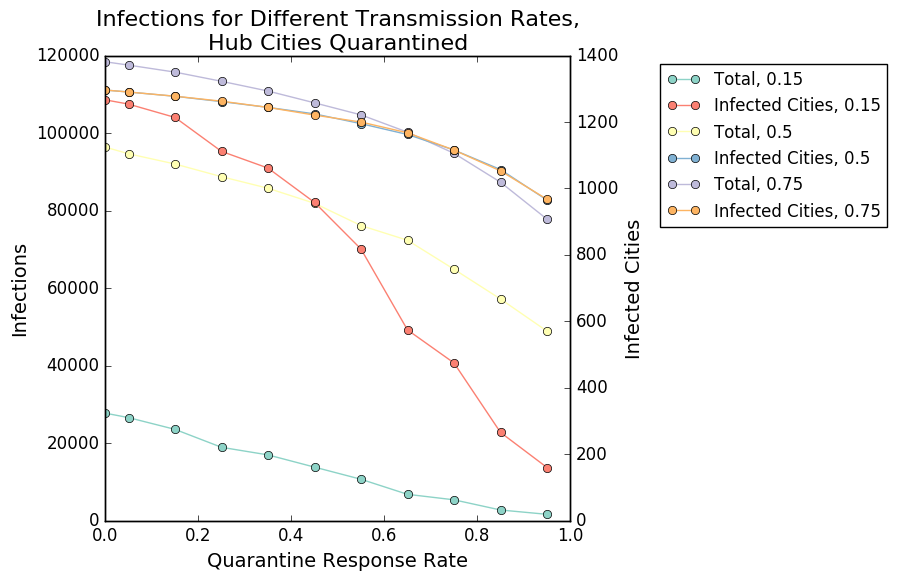

In [107]:
# Repeat for hub cities quarantined
all_on_one([hub_trans_15, hub_trans_50, hub_trans_75], True)

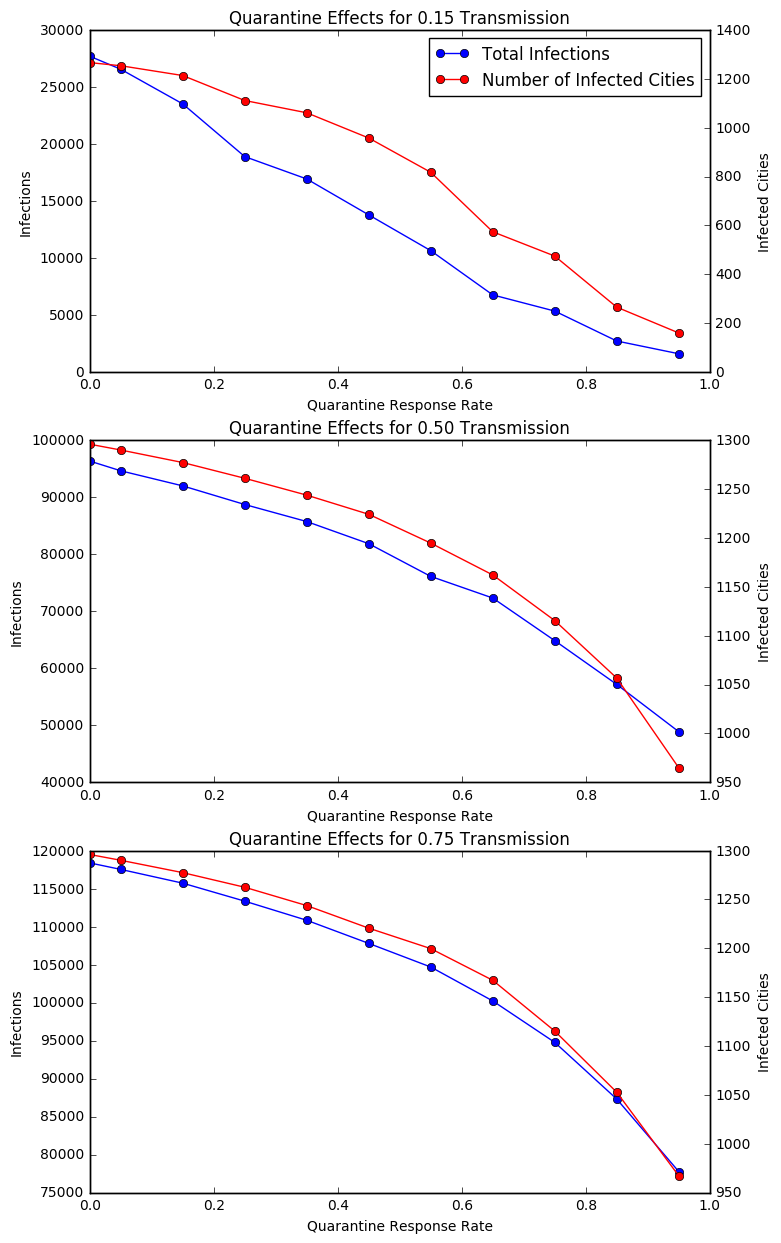

In [15]:
subplotting_wrapper([hub_trans_15, hub_trans_50, hub_trans_75])

In [39]:
def make_means(df):
    """ Given a dataframe with transmission rates of 0.15, 0.5, 
    and 0.75, returns a new dataframe of the average number
    of cities infected for each transmission rate.
    """
    df_means = pd.DataFrame()
    trans_rates = [0.15, 0.5, 0.75]
    for rate in trans_rates:
        df_means[rate] = df.loc[df.transmission == rate].groupby('quarantine').cities_infected.mean()
    return df_means

In [43]:
# Calculate the mean number of infected cities for the different
#  simulations.
df_means = make_means(all_quaran)
df_means

,0.15,0.5,0.75
quarantine,,,
0.00,1272.95,1295.97,1296.00
0.05,1084.48,1175.58,1149.57
0.15,713.99,845.01,826.23
0.25,348.31,562.74,556.17
0.35,93.20,195.86,210.14
0.45,31.17,42.26,58.44
0.55,6.14,6.05,9.89
0.65,3.04,2.15,3.08
0.75,1.70,1.68,1.53


In [44]:
df_means_hubs = make_means(hub_quaran)
df_means_hubs

,0.15,0.5,0.75
quarantine,,,
0.00,1266.46,1296.00,1296.00
0.05,1253.68,1290.05,1290.08
0.15,1213.54,1277.23,1277.42
0.25,1111.31,1261.11,1262.46
0.35,1061.05,1243.86,1243.71
0.45,957.69,1224.24,1220.59
0.55,817.31,1194.76,1199.66
0.65,573.79,1162.17,1167.24
0.75,474.32,1115.44,1115.26


In [46]:
# Calculate the ratio between the number of infected cities and
#  the number of cities still in the simulation. A quarantined city
#  is no longer considered to be a part of the simulation.

cities_infected_vs_cities_in_graph = pd.DataFrame()
cities_infected_vs_cities_in_graph[.15] = df_means[.15] / (1300 * (1 - df_means.index))
cities_infected_vs_cities_in_graph[.5] = df_means[.5] / (1300 * (1 - df_means.index))
cities_infected_vs_cities_in_graph[.75] = df_means[.75] / (1300 * (1 - df_means.index))

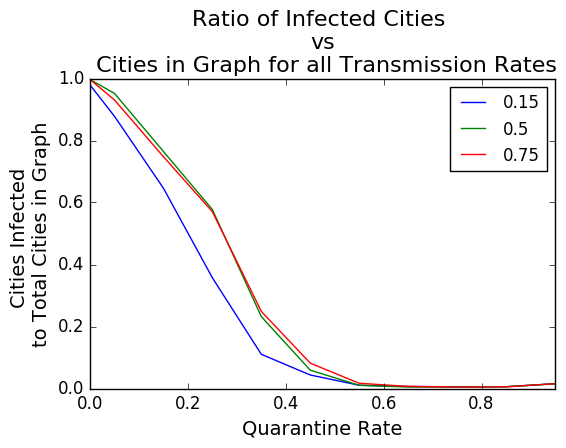

In [110]:
cities_infected_vs_cities_in_graph.plot()
plt.title('Ratio of Infected Cities \nvs\n Cities in Graph for all Transmission Rates')
plt.ylabel("Cities Infected \nto Total Cities in Graph")
plt.xlabel("Quarantine Rate")

In [48]:
# Calculate the number of cities not infected (not including the 
#  quarantined cities) for each city under quarantine. This gives
#  'effect' of each city quarantined.

cities_safe_per_city_removed = pd.DataFrame()
cities_safe_per_city_removed[.15] = ((1300 - df_means[.15])-(1300 * df_means.index)) / (1300 * df_means.index)
cities_safe_per_city_removed[.5] = ((1300 - df_means[.5])- (1300 * df_means.index)) / (1300 * df_means.index)
cities_safe_per_city_removed[.75] = ((1300 - df_means[.75]) - (1300 * df_means.index)) / (1300 * df_means.index)

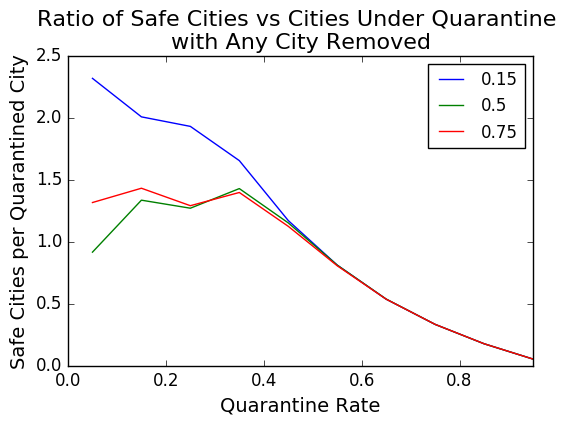

In [114]:
cities_safe_per_city_removed.plot()
plt.title('Ratio of Safe Cities vs Cities Under Quarantine \nwith Any City Removed')
plt.ylabel("Safe Cities per Quarantined City")
plt.xlabel("Quarantine Rate")

In [51]:
# At zero percent quarantine, we divide by zero, so it appears infinite
cities_safe_per_city_removed

,0.15,0.5,0.75
quarantine,,,
0.00,inf,inf,inf
0.05,2.315692,0.914154,1.314308
0.15,2.005179,1.333282,1.429590
0.25,1.928277,1.268492,1.288708
0.35,1.652308,1.426681,1.395297
0.45,1.168940,1.149983,1.122325
0.55,0.809594,0.809720,0.804350
0.65,0.534864,0.535917,0.534817
0.75,0.331590,0.331610,0.331764


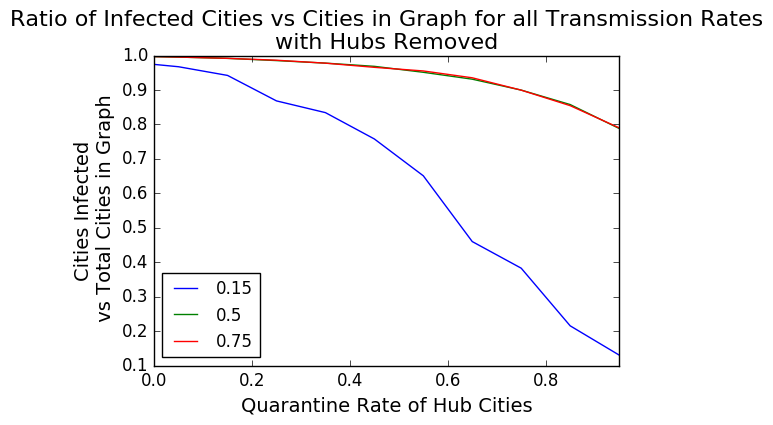

In [116]:
# Repeat with hub cities quarantined.
#  There are 80 cities which are considered hubs
cities_infected_vs_cities_in_graph_hub = pd.DataFrame()
cities_infected_vs_cities_in_graph_hub[.15] = df_means_hubs[.15] / (1300  - (80*df_means_hubs.index))
cities_infected_vs_cities_in_graph_hub[.5] = df_means_hubs[.5] / (1300  -  (80*df_means_hubs.index))
cities_infected_vs_cities_in_graph_hub[.75] = df_means_hubs[.75] / (1300 -  (80*df_means_hubs.index))

cities_infected_vs_cities_in_graph_hub.plot()
plt.title('Ratio of Infected Cities vs Cities in Graph for all Transmission Rates\nwith Hubs Removed')
plt.ylabel("Cities Infected\n vs Total Cities in Graph")
plt.xlabel("Quarantine Rate of Hub Cities")

In [53]:
cities_safe_per_hub_removed = pd.DataFrame()
cities_safe_per_hub_removed[.15] = ((1300 - df_means_hubs[.15])-(80 * df_means_hubs.index)) / (80 * df_means_hubs.index)
cities_safe_per_hub_removed[.5] = ((1300 - df_means_hubs[.5]) - (80 * df_means_hubs.index)) / (80 * df_means_hubs.index)
cities_safe_per_hub_removed[.75] = ((1300 - df_means_hubs[.75]) - (80 * df_means_hubs.index)) / (80 * df_means_hubs.index)


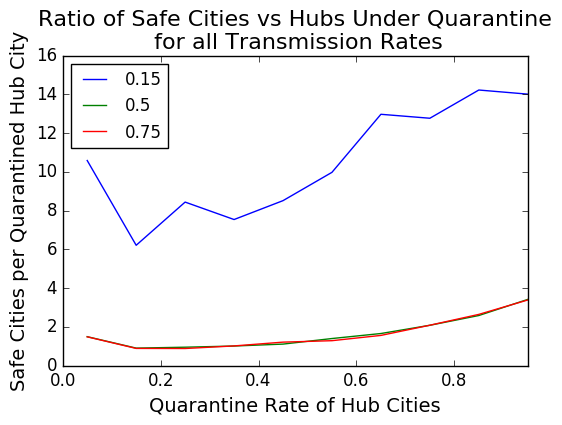

In [118]:
cities_safe_per_hub_removed.plot()
plt.title('Ratio of Safe Cities vs Hubs Under Quarantine\n for all Transmission Rates')
plt.ylabel("Safe Cities per Quarantined Hub City")
plt.xlabel("Quarantine Rate of Hub Cities")